## Auxotrophic Growth of ADP1 ISx strains on Arginine
This is a revisit of analytical framework prompted by:
1. prep for the MBP MidTerm Progress Report
2. Keith's recent slack with some FoldIncrease calculations

### Quick Notes
- I've been approaching my calculations with the idea that two main functions should suffice for my theoretical modeling of Arg-aux growth:
    1. x_Arg(OD600_init, abundance_CGP_in_CDW, consts) 
    2. OD600(x_Arg, consts)
- I've highlighted the differences from Keith's assumptions in values of constants
- I closely recapitulated Keith's fold increase calculations (11/05/2024)
- I realized that the `[Arg] from BM w/CGP` curves I've been using need a bit more explanation - at least graphically:
    - I'm using the OD600 scale for both OD600_init for `[Arg] from BM w/CGP` and OD600_final for the yield curves.
- I've been constructing the combined unit Yield as OD_phaseII from OD_phaseI, that naming is confusing because OD_phaseII is independent of OD_phaseI and is solely dependent on starting OD in phaseII and CGP(%CDW) from 

In [54]:
from functools import partial

from sympy import symbols, Eq, plot, Function, N
from sympy.physics.units.prefixes import micro
from sympy.physics.units import au, gram, liter, milliliter, mol

In [45]:
# numeric rounding to 3 sig figs
N3 = partial(N, n=3)

# additional units
molar = mol / liter
wv_perc = gram / (100 * milliliter)

In [3]:
# symbols
Real = partial(symbols, real=True)

# species
CGP, Arg, Asp, prot = Real('CGP, Arg, Asp, prot')

# abundances
ab_Arg_in_CGP = Real(r'abundance_{\frac{Arg}{CGP}}')
ab_Asp_in_CGP = Real(r'abundance_{\frac{Asp}{CGP}}')
ab_CGP_in_CDW = Real(r'abundance_{\frac{CGP}{CDW}}')
ab_prot_in_CDW = Real(r'abundance_{\frac{prot}{CDW}}')
ab_Arg_in_prot = Real(r'abundance_{\frac{Arg}{prot}}')

# masses
m_Arg, m_CGP, CDW = Real('m_{Arg}, m_{CGP}, CDW')

# molar weights
mw_Arg, mw_Asp = Real('mw_{Arg}, mw_{Asp}')

# concentrations
x_Arg = Real(r'x_{Arg}')
x_CGP = Real(r'x_{CGP}')
OD600_initial, OD600 = Real(r'OD600_{init}, OD600')

ratio_CDW_per_OD600 = Real(r'ratio_{\frac{CDW}{OD600}}')

# yields
Y_OD_from_Arg = Real(r'Y_{\frac{OD600}{Arg}}')
Y_OD_from_CGP = Real(r'Y_{\frac{OD600}{CGP}}')
Y_ODp2_from_ODp1 = Real(r'Y_{\frac{OD600_{phase2}}{OD600_{phase1}}}')
Y_CDWp2_from_CDWp1 = Real(r'Y_{\frac{CDW_{phase2}}{CDW_{phase1}}}')

In [22]:
# FIXME - differs from Keith's assumptions

const = {
    # molar weights
    mw_Arg: 174.2 * gram / mol,
    mw_Asp: 133.1 * gram / mol,

    # abundances
    ab_Arg_in_CGP: 0.60,  # FIXME accounting for one H2O loss 174.2 / (174.2 + 133.1 - 18)
    # ab_CGP_in_CDW: 0.25,  # working assumption (previously considered conservative)
    ab_Arg_in_prot: 0.05,  # 1/20 of all proteins (confirmed in cheminfo.ipynb)
    ab_prot_in_CDW: 0.50,  # 1/2 of cell dry weight presumed to be proteins

    # conversions
    ratio_CDW_per_OD600: .33 * (gram / liter) / au
    # FIXME based on https://bionumbers.hms.harvard.edu/bionumber.aspx?id=109838&ver=2 
}

### Theoretical arginine demand by proteome (growth limiting)

This is a theoretical upper bound on cellular growth, as we expect the highest priority for arginine utilization to be expression of the proteome.

In [23]:
(ab_Arg_in_CDW := ab_prot_in_CDW * ab_Arg_in_prot)

abundance_{\frac{Arg}{prot}}*abundance_{\frac{prot}{CDW}}

In [24]:
ab_Arg_in_CDW.subs(const)

0.0250000000000000

In [25]:
(eq_OD_from_Arg := Eq(OD600, x_Arg / (ratio_CDW_per_OD600 * ab_Arg_in_CDW / mw_Arg)))

Eq(OD600, mw_{Arg}*x_{Arg}/(abundance_{\frac{Arg}{prot}}*abundance_{\frac{prot}{CDW}}*ratio_{\frac{CDW}{OD600}}))

In [46]:
N3(eq_OD_from_Arg.subs(const))

Eq(OD600, 2.11e+4*astronomical_unit*liter*x_{Arg}/mole)

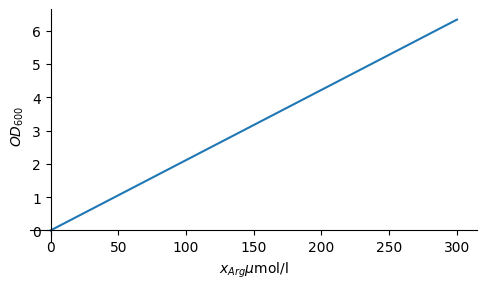

In [110]:
plot(
    eq_OD_from_Arg.subs(const).rhs * (micro * mol / liter) / au,
    (x_Arg, 0, 300),
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD600,
    size=(5, 3),
)

### Accumulated CGP as source of Arginine

ALE Phases with auxotrophic stains:

- Phase I - inoculation from pre-culture, growth and accumulation of CGP
- Phase II - inoculation from cultures from Phase I, growth limited by Arg from 

CGP is accumulated in Phase I and consumed in Phase II of ALE.

In [111]:
Function(OD600)(OD600_initial, ab_CGP_in_CDW)

OD600(OD600_{init}, abundance_{\frac{CGP}{CDW}})

In [112]:
# But abundance_CGP_in_CDW is measurable value, therefore
Function(OD600)(OD600_initial)

OD600(OD600_{init})

In [113]:
# we know how to estimate OD based on Arg concentration, so we need a function to predict Arg concentration:
Function(x_Arg)(OD600_initial, ab_CGP_in_CDW)

x_{Arg}(OD600_{init}, abundance_{\frac{CGP}{CDW}})

In [114]:
(eq_x_Arg_from_OD_init := Eq(x_Arg, OD600_initial * ratio_CDW_per_OD600 * ab_CGP_in_CDW * ab_Arg_in_CGP / mw_Arg))

Eq(x_{Arg}, OD600_{init}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}}/mw_{Arg})

In [115]:
# lower bound on x_Arg from 0.05 ODinit and 10 CGP(%CDW) (realistic)
N3(eq_x_Arg_from_OD_init.subs({OD600_initial: .05 * au, ab_CGP_in_CDW: 0.10}).subs(const))

Eq(x_{Arg}, 5.68e-6*mole/liter)

In [116]:
# upper bound on x_Arg from 0.20 ODinit and 60 CGP(%CDW) (supremely optimistic)
N3(eq_x_Arg_from_OD_init.subs({OD600_initial: .20 * au, ab_CGP_in_CDW: 0.60}).subs(const))

Eq(x_{Arg}, 0.000136*mole/liter)

In [119]:
# combine OD600 and x_Arg functions (example)
N3(eq_OD_from_Arg.subs({x_Arg: eq_x_Arg_from_OD_init.rhs}).subs(const).subs(
    {OD600_initial: .1 * au, ab_CGP_in_CDW: .25}))

Eq(OD600, 0.6*astronomical_unit)

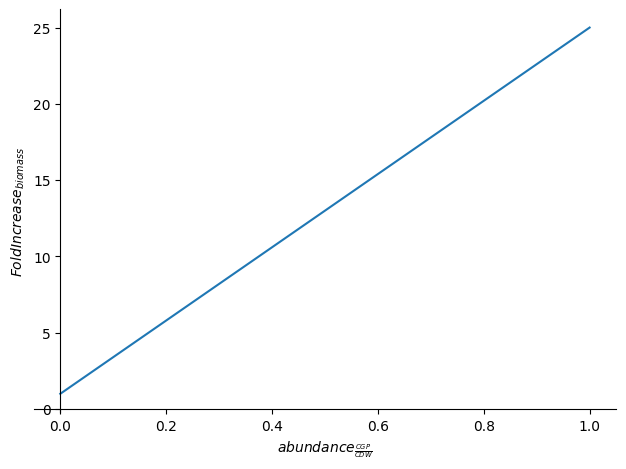

In [121]:
# plot fold increase based on OD :: should be equivalent to Keith's gCDW, since linearly related.
plot(
    ((OD600 + OD600_initial) / OD600_initial).subs({
        OD600: eq_OD_from_Arg.rhs,
        x_Arg: eq_x_Arg_from_OD_init.rhs,
    }).subs(const).subs({OD600_initial: .1 * au}),
    (ab_CGP_in_CDW, 0, 1),
    ylabel=symbols('FoldIncrease_{biomass}'),
)